In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.io as pio

pio.renderers.default = "notebook"  # or "iframe", "vscode", etc. depending on your environment

# Set plot style
sns.set(style="whitegrid")

# === Load both files ===
may_5_df = pd.read_csv("../datasets/all_trips_05_05.csv", parse_dates=["start_time", "end_time"])
may_11_df = pd.read_csv("../datasets/all_trips_05_11.csv", parse_dates=["start_time", "end_time"])

# Load station stats files
stats_05 = pd.read_csv("../datasets/station_stats_2022-05-05.csv")
stats_11 = pd.read_csv("../datasets/station_stats_2022-05-11.csv")

stations_df = pd.read_csv("../datasets/all_stations.csv")  # adjust path if needed
station_name_map = stations_df.set_index("station_id")["station_name"].to_dict()
# Add date info
dfs = [(may_5_df, "2022-05-05"), (may_11_df, "2022-05-11")]
for df, label in dfs:
    df['hour'] = df['start_time'].dt.hour
    df['15min'] = df['start_time'].dt.floor('15min')
    df['date'] = label

# Combine for comparison
combined_df = pd.concat([may_5_df, may_11_df])

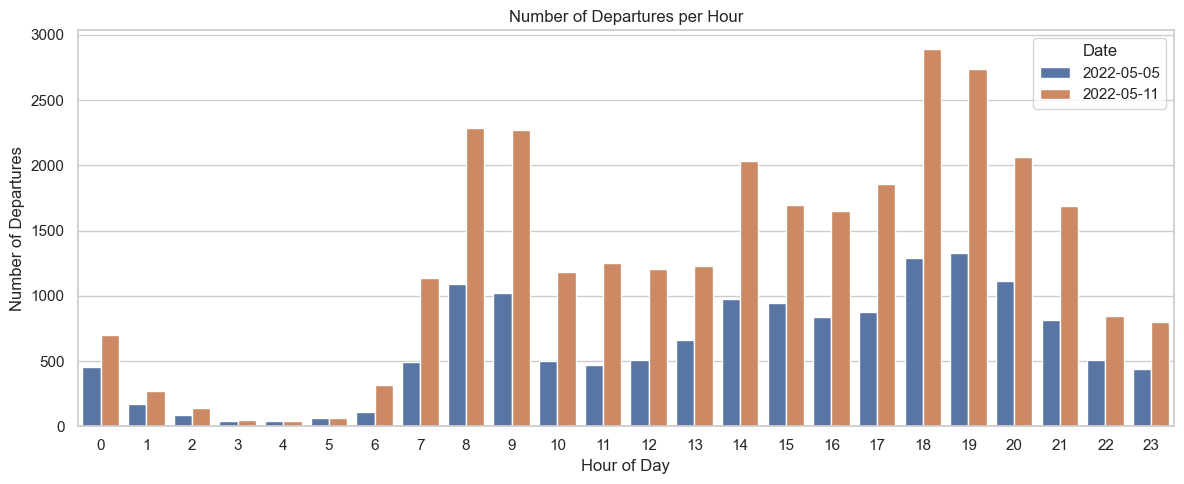

In [37]:
# === 1. Average Number of Departures per Hour ===
plt.figure(figsize=(12, 5))
sns.countplot(data=combined_df, x="hour", hue="date")
plt.title("Number of Departures per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Departures")
plt.legend(title="Date")
plt.tight_layout()
plt.show()

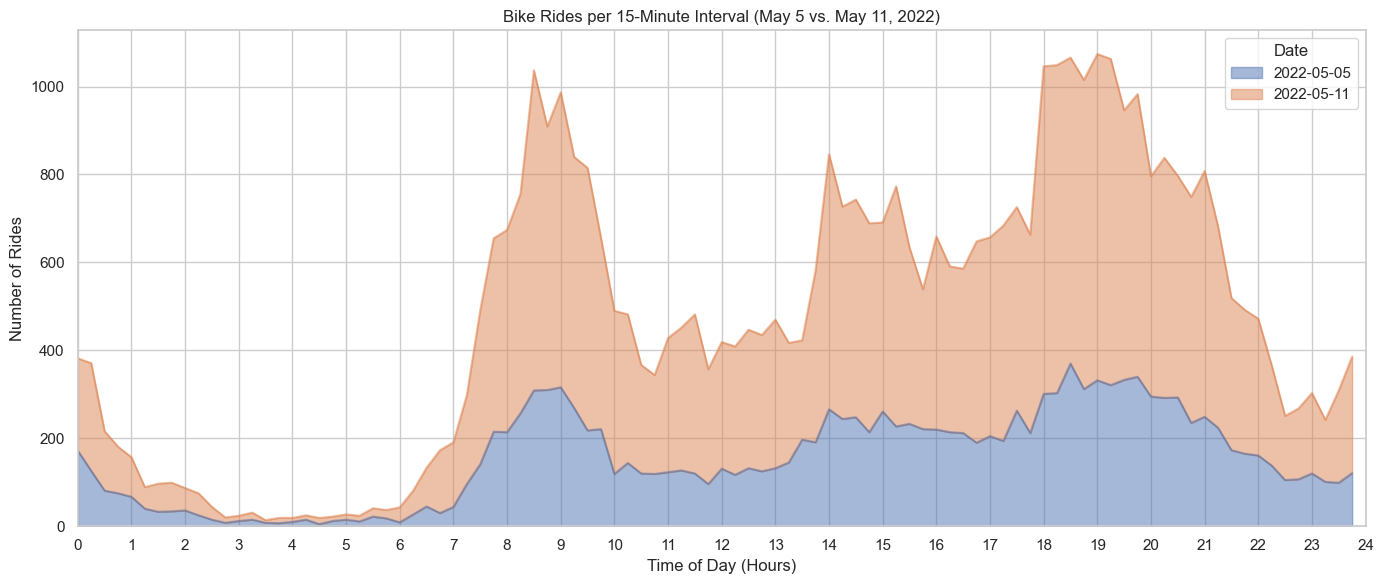

In [38]:
# === 2. Rides per 15-Minute Interval ===
# Group by 15-minute bins and date
rides_per_15min = (
    combined_df.groupby(['15min', 'date'])
    .size()
    .reset_index(name='ride_count')
)

# Convert time to decimal hours for x-axis
rides_per_15min['time_of_day'] = rides_per_15min['15min'].dt.hour + rides_per_15min['15min'].dt.minute / 60

# Pivot to have each date as a column
pivot_df = rides_per_15min.pivot(index='time_of_day', columns='date', values='ride_count').fillna(0)

# Plot
plt.figure(figsize=(14, 6))
pivot_df.plot(kind='area', alpha=0.5, ax=plt.gca())

plt.title("Bike Rides per 15-Minute Interval (May 5 vs. May 11, 2022)")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Number of Rides")
plt.xlim(0, 24)
plt.xticks(range(0, 25, 1))
plt.legend(title="Date")
plt.grid(True)
plt.tight_layout()
plt.show()

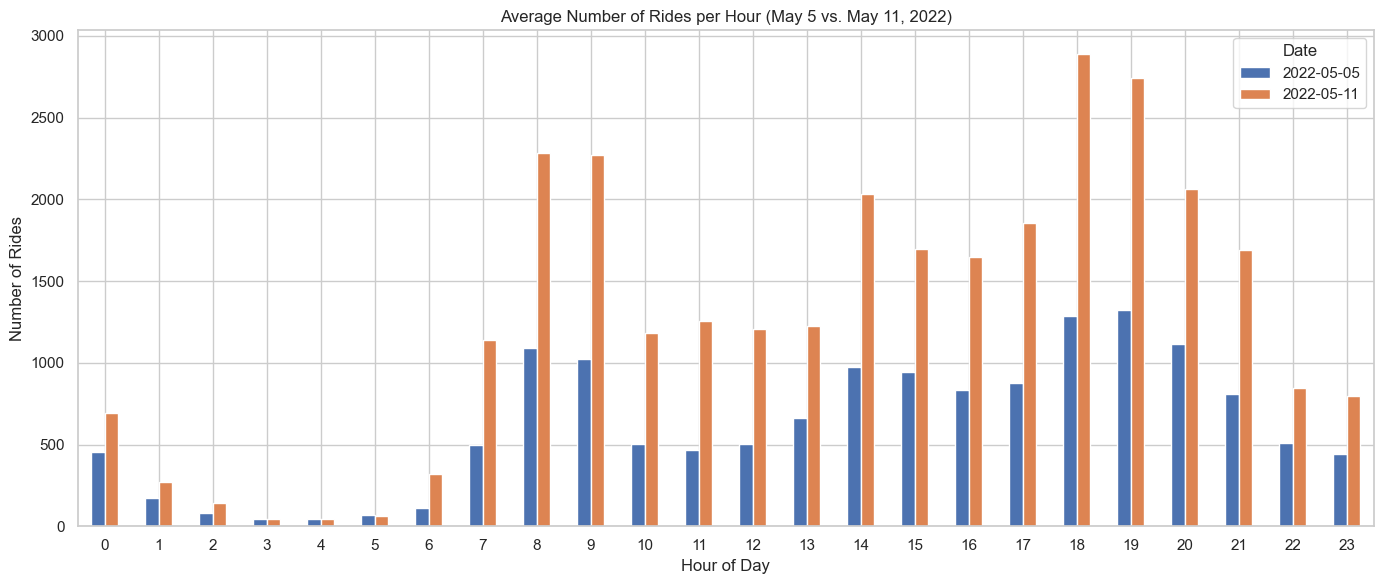

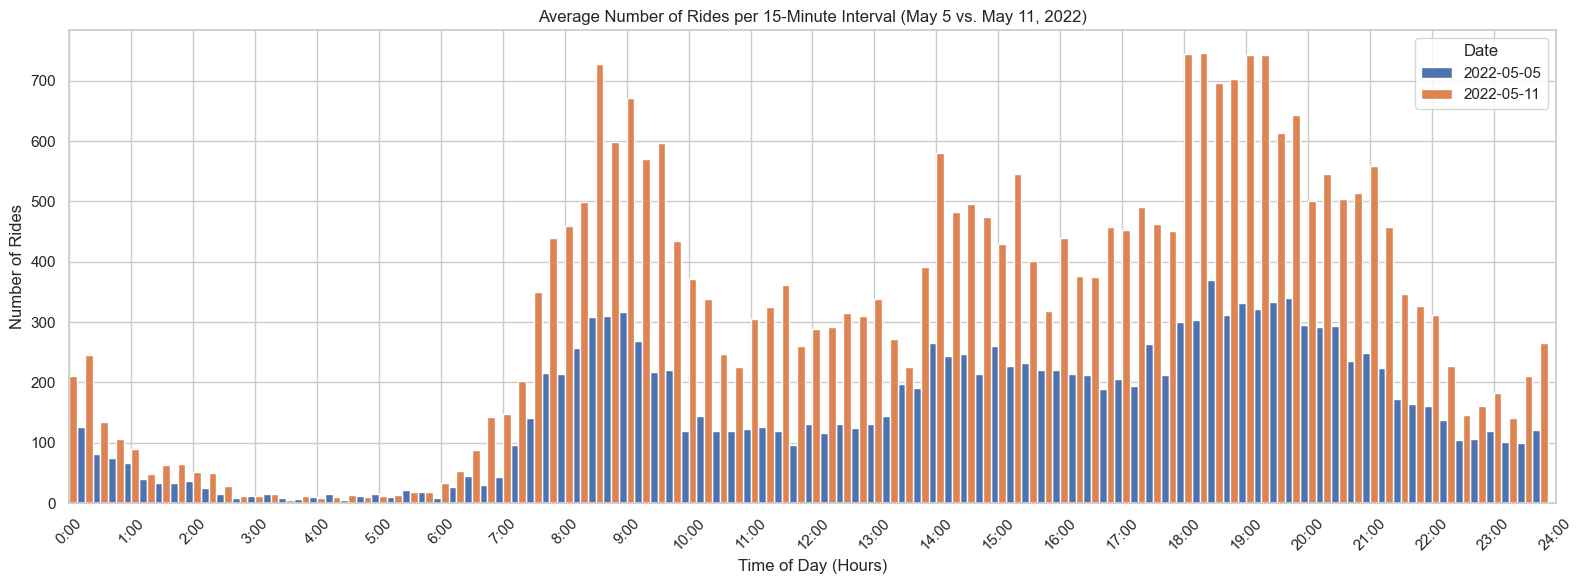

In [39]:
# === 3. Average Ride Duration per Hour & per 15min ===
# Group by hour and date, then count rides
rides_per_hour = (
    combined_df.groupby(['hour', 'date'])
    .size()
    .reset_index(name='ride_count')
)

# Pivot to have dates as columns
pivot_hour_df = rides_per_hour.pivot(index='hour', columns='date', values='ride_count').fillna(0)

# Plot
plt.figure(figsize=(14, 6))
pivot_hour_df.plot(kind='bar', ax=plt.gca())

plt.title("Average Number of Rides per Hour (May 5 vs. May 11, 2022)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(rotation=0)
plt.legend(title="Date")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Group by 15-minute intervals and date
rides_per_15min = (
    combined_df.groupby(['15min', 'date'])
    .size()
    .reset_index(name='ride_count')
)

# Convert time to decimal hours for x-axis
rides_per_15min['time_of_day'] = rides_per_15min['15min'].dt.hour + rides_per_15min['15min'].dt.minute / 60

# Pivot to have each date as a column
pivot_df = rides_per_15min.pivot(index='time_of_day', columns='date', values='ride_count').fillna(0)

# Plot
plt.figure(figsize=(16, 6))
pivot_df.plot(kind='bar', width=1.0, ax=plt.gca())

plt.title("Average Number of Rides per 15-Minute Interval (May 5 vs. May 11, 2022)")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Number of Rides")
plt.xlim(0, 24)
plt.xticks(ticks=range(0, 97, 4), labels=[f"{h}:00" for h in range(0, 25)], rotation=45)  # every hour
plt.legend(title="Date")
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

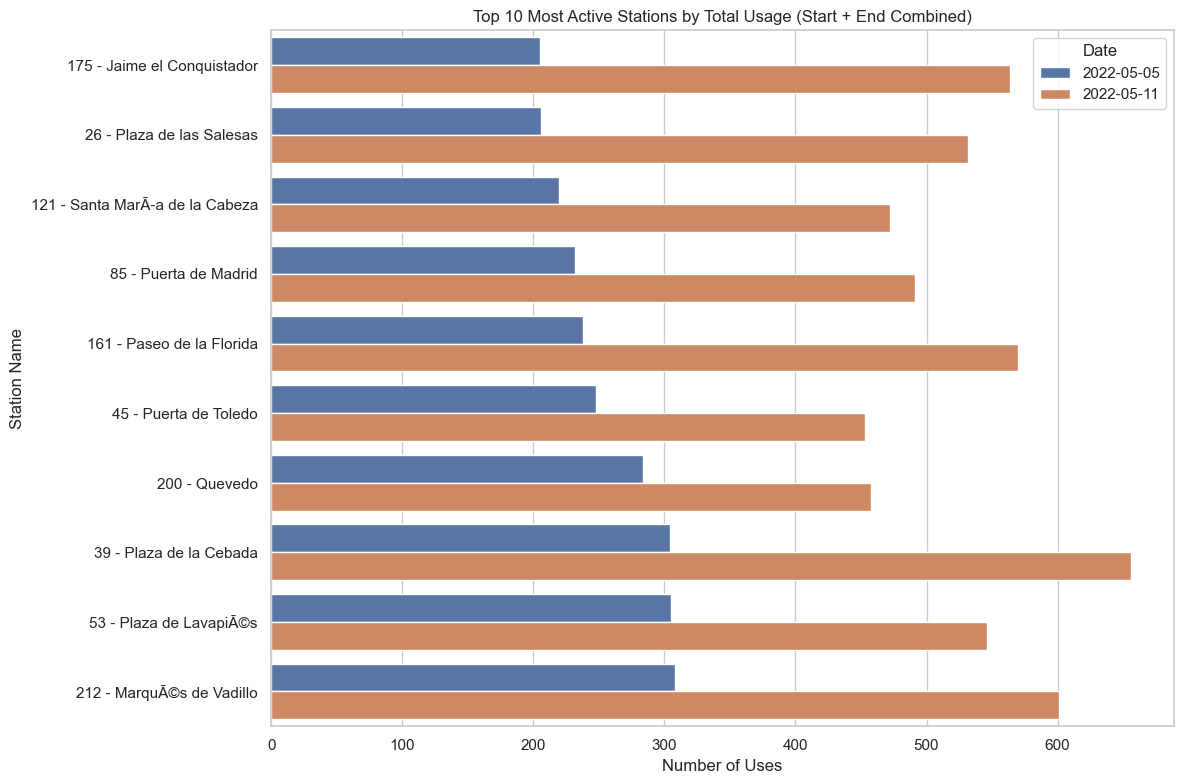

In [40]:
# === 4. Top 10 Most Active Stations by Total Usage ===

def get_station_usage(df, date_label):
    # Count trips starting and ending at each station
    start_counts = df['start_station_id'].value_counts().rename('starts')
    end_counts = df['end_station_id'].value_counts().rename('ends')

    total_counts = pd.concat([start_counts, end_counts], axis=1).fillna(0)
    total_counts['total'] = total_counts['starts'] + total_counts['ends']
    total_counts['station_id'] = total_counts.index

    # Map station names
    total_counts['station_name'] = total_counts['station_id'].map(station_name_map)
    total_counts['date'] = date_label

    return total_counts[['station_id', 'station_name', 'total', 'date']]

# Get usage for both days
may5_usage = get_station_usage(may_5_df, "2022-05-05")
may11_usage = get_station_usage(may_11_df, "2022-05-11")

# Combine and find top 10 stations by total usage
usage_combined = pd.concat([may5_usage, may11_usage])
top_station_ids = usage_combined.groupby('station_id')['total'].sum().nlargest(10).index
top_stations = usage_combined[usage_combined['station_id'].isin(top_station_ids)]

# Sort for clean plotting
top_stations = top_stations.sort_values(by='total', ascending=True)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_stations,
    y='station_name',
    x='total',
    hue='date'
)

plt.title("Top 10 Most Active Stations by Total Usage (Start + End Combined)")
plt.xlabel("Number of Uses")
plt.ylabel("Station Name")
plt.legend(title="Date")
plt.tight_layout()
plt.show()

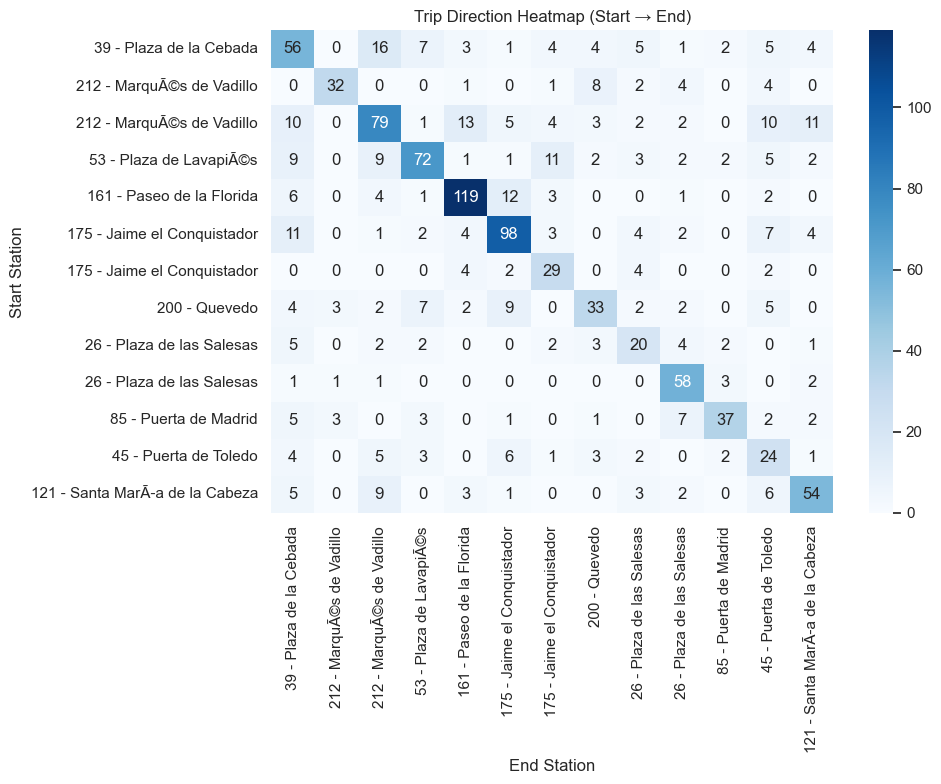

In [41]:
# === 5. Trip Direction Heatmap ===
# Create trip matrix
trip_matrix = combined_df.groupby(['start_station_id', 'end_station_id']).size().unstack(fill_value=0)

# Optionally map station IDs to names
trip_matrix.index = trip_matrix.index.map(station_name_map)
trip_matrix.columns = trip_matrix.columns.map(station_name_map)

# Limit to top N busiest stations (optional)
top_stations = (
    pd.concat([combined_df['start_station_id'], combined_df['end_station_id']])
    .value_counts()
    .head(10)
    .index
)

top_station_names = [station_name_map.get(i, str(i)) for i in top_stations]
trip_matrix_filtered = trip_matrix.loc[top_station_names, top_station_names]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(trip_matrix_filtered, annot=True, fmt='d', cmap='Blues')

plt.title("Trip Direction Heatmap (Start → End)")
plt.xlabel("End Station")
plt.ylabel("Start Station")
plt.tight_layout()
plt.show()

C:\Users\Iva Nikolova\AppData\Local\Temp\ipykernel_17776\2942791532.py:76: UserWarning:

Glyph 128 (\x80) missing from font(s) Arial.

C:\Users\Iva Nikolova\AppData\Local\Temp\ipykernel_17776\2942791532.py:76: UserWarning:

Glyph 153 (\x99) missing from font(s) Arial.

c:\Users\Iva Nikolova\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128 (\x80) missing from font(s) Arial.

c:\Users\Iva Nikolova\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 153 (\x99) missing from font(s) Arial.



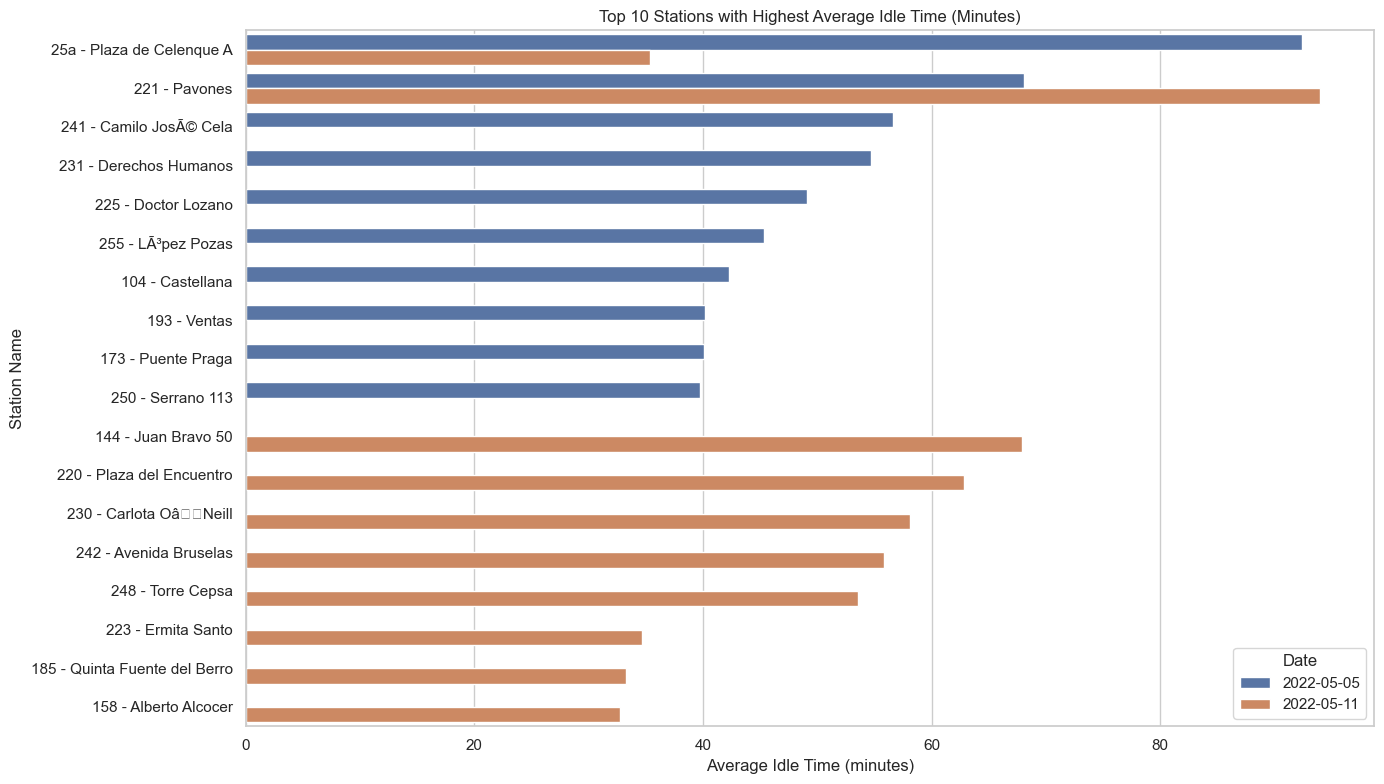

In [42]:
# === 6. Top 10 Stations with Highest Average Wait Until Next Unlock ===

def compute_idle_times(df, date_label):
    # Select needed columns
    relevant = df[['start_station_id', 'start_time', 'end_station_id', 'end_time']].copy()
    
    # Rename for clarity
    relevant.rename(columns={
        'start_station_id': 'unlock_station_id',
        'start_time': 'unlock_time',
        'end_station_id': 'lock_station_id',
        'end_time': 'lock_time'
    }, inplace=True)

    # Combine lock and unlock events into one table
    lock_events = relevant[['lock_station_id', 'lock_time']].rename(columns={
        'lock_station_id': 'station_id',
        'lock_time': 'event_time'
    })
    lock_events['event_type'] = 'lock'

    unlock_events = relevant[['unlock_station_id', 'unlock_time']].rename(columns={
        'unlock_station_id': 'station_id',
        'unlock_time': 'event_time'
    })
    unlock_events['event_type'] = 'unlock'

    # Merge both and sort
    events = pd.concat([lock_events, unlock_events])
    events.sort_values(by=['station_id', 'event_time'], inplace=True)

    # For each station, calculate idle time = unlock_time - previous lock_time
    idle_times = []

    for station_id, group in events.groupby('station_id'):
        group = group.reset_index(drop=True)
        last_lock_time = None
        for _, row in group.iterrows():
            if row['event_type'] == 'lock':
                last_lock_time = row['event_time']
            elif row['event_type'] == 'unlock' and last_lock_time:
                idle = (row['event_time'] - last_lock_time).total_seconds() / 60.0  # minutes
                if idle >= 0:
                    idle_times.append({'station_id': station_id, 'idle_minutes': idle, 'date': date_label})
                last_lock_time = None  # reset to avoid double-counting

    return pd.DataFrame(idle_times)

# Compute for both days
may5_idle = compute_idle_times(may_5_df, "2022-05-05")
may11_idle = compute_idle_times(may_11_df, "2022-05-11")

# Combine and calculate average idle time per station
all_idle = pd.concat([may5_idle, may11_idle])
avg_idle = all_idle.groupby(['station_id', 'date'])['idle_minutes'].mean().reset_index()

# Map station names
avg_idle['station_name'] = avg_idle['station_id'].map(station_name_map)

# Get top 10 per day
top10_idle = avg_idle.sort_values(['date', 'idle_minutes'], ascending=[True, False]).groupby('date').head(10)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top10_idle,
    y='station_name',
    x='idle_minutes',
    hue='date'
)

plt.title("Top 10 Stations with Highest Average Idle Time (Minutes)")
plt.xlabel("Average Idle Time (minutes)")
plt.ylabel("Station Name")
plt.legend(title="Date")
plt.tight_layout()
plt.show()


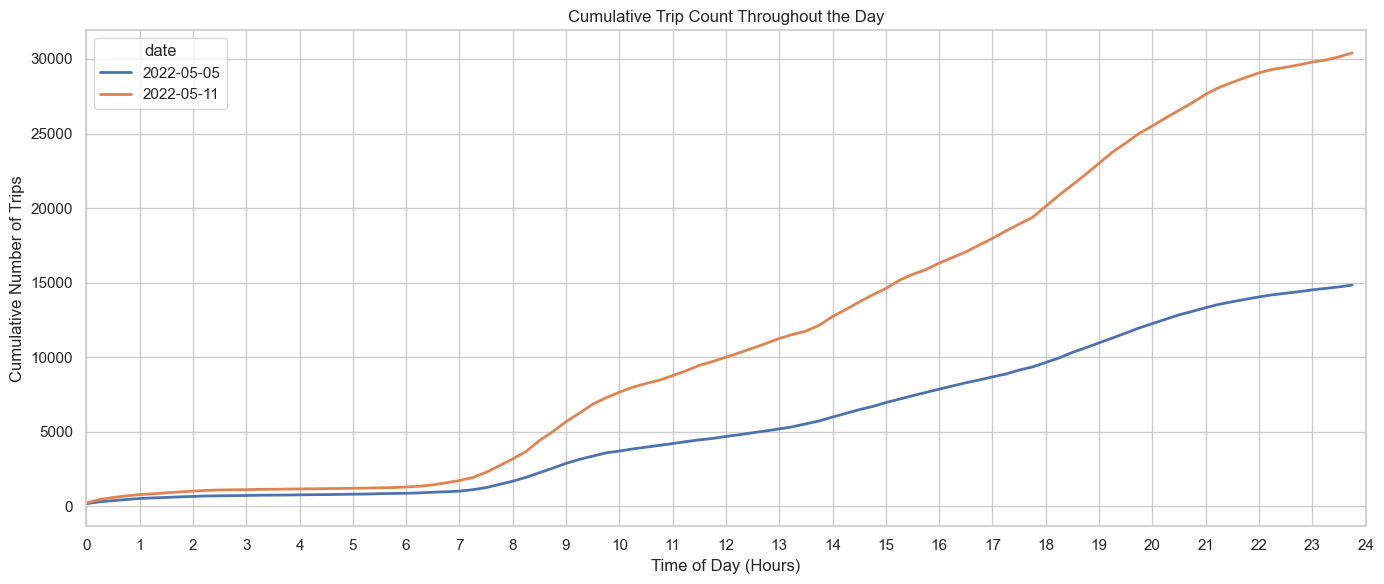

In [43]:
# === 7. Cumulative Trip Count Over the Day ===
# Group trips per 15-minute interval and count
trip_counts = combined_df.groupby(['15min', 'date']).size().reset_index(name='count')

# Sort and compute cumulative sum
trip_counts.sort_values(by=['date', '15min'], inplace=True)
trip_counts['cumulative_count'] = trip_counts.groupby('date')['count'].cumsum()

# Convert time for x-axis
trip_counts['time_of_day'] = trip_counts['15min'].dt.hour + trip_counts['15min'].dt.minute / 60

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=trip_counts, x='time_of_day', y='cumulative_count', hue='date', linewidth=2)

plt.title("Cumulative Trip Count Throughout the Day")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Cumulative Number of Trips")
plt.xlim(0, 24)
plt.xticks(range(0, 25, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

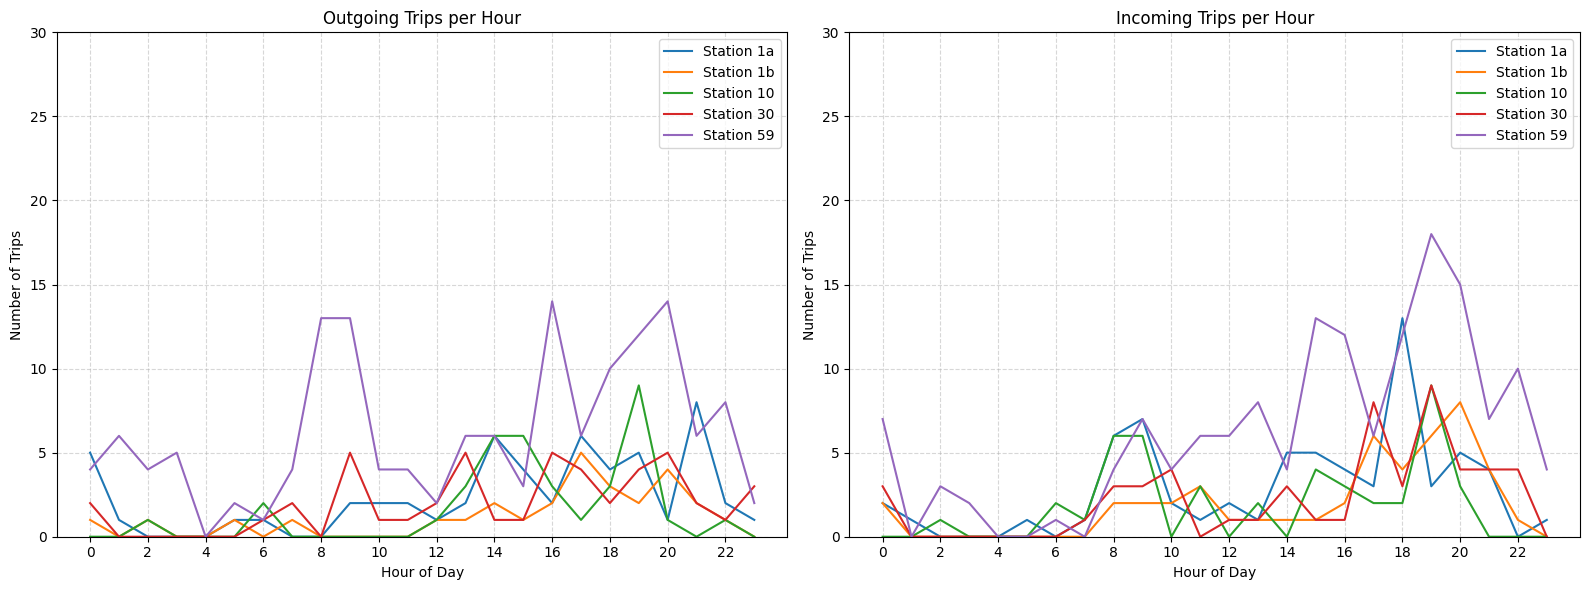

In [ ]:
# === 8. Number of outgoing and incoming trips per station, per hour for May 5th ===
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

trips = pd.read_csv("../datasets/all_trips_05_05.csv", parse_dates=["start_time", "end_time"])

trips["start_station_id"] = trips["start_station_id"].astype(str)
trips["end_station_id"] = trips["end_station_id"].astype(str)
trips["start_hour"] = trips["start_time"].dt.hour
trips["end_hour"] = trips["end_time"].dt.hour

# Count trips
outgoing = defaultdict(lambda: defaultdict(int))
incoming = defaultdict(lambda: defaultdict(int))

for _, row in trips.iterrows():
    outgoing[row["start_station_id"]][row["start_hour"]] += 1
    incoming[row["end_station_id"]][row["end_hour"]] += 1

# Pick stations to inspect
selected_stations = ["1a", "1b", "10", "30", "59"]

out_df = pd.DataFrame({sid: pd.Series(hour_counts) for sid, hour_counts in outgoing.items() if sid in selected_stations}).fillna(0)
in_df = pd.DataFrame({sid: pd.Series(hour_counts) for sid, hour_counts in incoming.items() if sid in selected_stations}).fillna(0)
out_df = out_df.reindex(range(24)).fillna(0)
in_df = in_df.reindex(range(24)).fillna(0)

plt.figure(figsize=(16, 6))

# Outgoing Trips
plt.subplot(1, 2, 1)
for sid in selected_stations:
    plt.plot(out_df.index, out_df[sid], label=f"Station {sid}")
plt.title("Outgoing Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.ylim(0, 30)
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Incoming Trips
plt.subplot(1, 2, 2)
for sid in selected_stations:
    plt.plot(in_df.index, in_df[sid], label=f"Station {sid}")
plt.title("Incoming Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.ylim(0, 30)
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


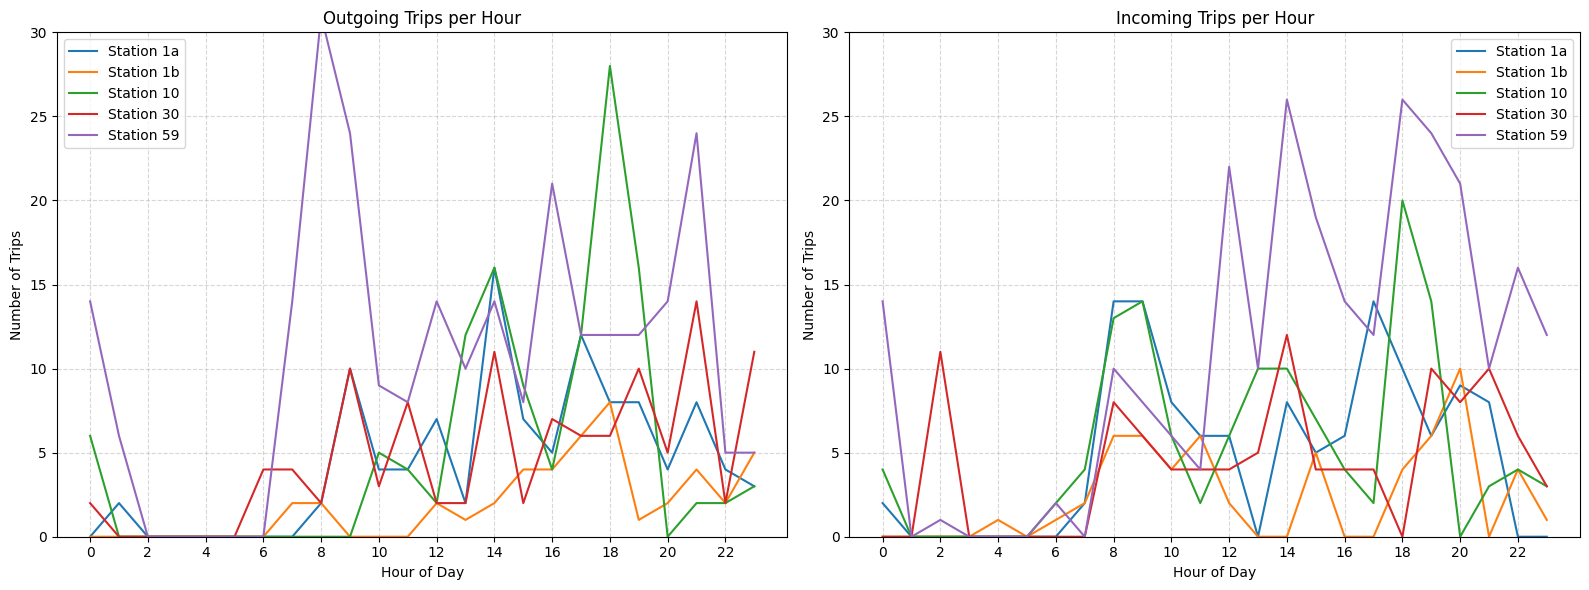

In [ ]:
# === 9. Number of outgoing and incoming trips per station, per hour for May 11th ===
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

trips = pd.read_csv("../datasets/all_trips_05_11.csv", parse_dates=["start_time", "end_time"])

trips["start_station_id"] = trips["start_station_id"].astype(str)
trips["end_station_id"] = trips["end_station_id"].astype(str)
trips["start_hour"] = trips["start_time"].dt.hour
trips["end_hour"] = trips["end_time"].dt.hour

# Count trips
outgoing = defaultdict(lambda: defaultdict(int))
incoming = defaultdict(lambda: defaultdict(int))

for _, row in trips.iterrows():
    outgoing[row["start_station_id"]][row["start_hour"]] += 1
    incoming[row["end_station_id"]][row["end_hour"]] += 1

# Pick stations to inspect
selected_stations = ["1a", "1b", "10", "30", "59"]

out_df = pd.DataFrame({sid: pd.Series(hour_counts) for sid, hour_counts in outgoing.items() if sid in selected_stations}).fillna(0)
in_df = pd.DataFrame({sid: pd.Series(hour_counts) for sid, hour_counts in incoming.items() if sid in selected_stations}).fillna(0)
out_df = out_df.reindex(range(24)).fillna(0)
in_df = in_df.reindex(range(24)).fillna(0)

plt.figure(figsize=(16, 6))

# Outgoing Trips
plt.subplot(1, 2, 1)
for sid in selected_stations:
    plt.plot(out_df.index, out_df[sid], label=f"Station {sid}")
plt.title("Outgoing Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.ylim(0, 30)
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Incoming Trips
plt.subplot(1, 2, 2)
for sid in selected_stations:
    plt.plot(in_df.index, in_df[sid], label=f"Station {sid}")
plt.title("Incoming Trips per Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.ylim(0, 30)
plt.xticks(range(0, 24, 2))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


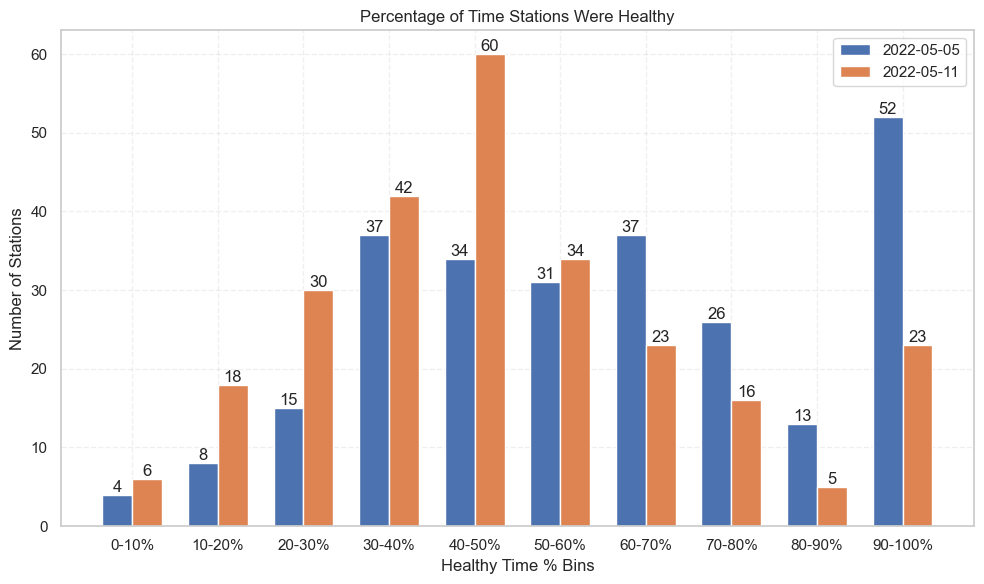

In [9]:
# === 10. The percentage of time, when stations are healthy ===
stats_05["healthy_time_percentage"] = stats_05["healthy_percentage"]
stats_11["healthy_time_percentage"] = stats_11["healthy_percentage"]

# Define bins and labels
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100.1]
labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]

# Categorize stations into bins
stats_05["bin"] = pd.cut(stats_05["healthy_time_percentage"], bins=bins, labels=labels, include_lowest=True)
stats_11["bin"] = pd.cut(stats_11["healthy_time_percentage"], bins=bins, labels=labels, include_lowest=True)

# Count how many stations fall into each bin
count_05 = stats_05["bin"].value_counts().sort_index()
count_11 = stats_11["bin"].value_counts().sort_index()

# Plot grouped bar chart
x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars_05 = plt.bar([i - width/2 for i in x], count_05, width, label="2022-05-05")
bars_11 = plt.bar([i + width/2 for i in x], count_11, width, label="2022-05-11")

# Add text labels on top of bars
for bar in bars_05:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom')
for bar in bars_11:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom')

plt.xticks(x, labels)
plt.xlabel("Healthy Time % Bins")
plt.ylabel("Number of Stations")
plt.title("Percentage of Time Stations Were Healthy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()
